# Likelihood Fit with iminuit
 >__Created__:  October 2021, Virtual, LPC Course: Statistics in Particle Physics.<br>
 >__Updated__: May 2022, INFN School of Statistics, Paestum, Italy
 
 
 This notebook gives a basic introduction to likelihood fits using the __Scikit_HEP__ module __iminuit__, which is a very convenient wrapper around the function miminization package Minuit, released in the CERN package __ROOT__. The tutorial is inspired in part by Glen Cowan's exercise at INFN SOS 2013, Vietri sul Mare, Italy. 
 
 The goal is to illustrate a very non-Gaussian likelihood function.

In [3]:
# standard system modules
import os, sys

# standard table manipulation module
#import pandas as pd

# standard array manipulation module
import numpy as np

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

# Minuit 
import iminuit as im

# standard symbolic algebra pakage
import sympy as sm

# standard plotting module
import matplotlib as mp
import matplotlib.pyplot as plt

# make plots appear inline
%matplotlib inline

In [4]:
# update fonts
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20
        }
mp.rc('font', **font)
mp.rc('xtick', labelsize='x-small')
mp.rc('ytick', labelsize='x-small')

# set usetex = False if Latex is not available on your system
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility 
# on a given machine
seed = 111
rnd = np.random.RandomState(seed)

### Load data

$m(x | a, b) = P \, a \exp(-a x) + (1-P) \, b \exp(-b x)$

Format of data file:
```python
F: P * np.exp(-x/a)/a + (1-P) * np.exp(-x/b)/b
A:      5.000
B:     10.000
P:      0.667
     2.659
    17.451
     0.621
    12.218
        :
```

In [5]:
def read_data(filename):
    
    # read all records
    records = [x.strip() for x in open(filename).readlines()]

    # get model formula
    model   = records[0].split(': ')[-1]

    # get true parameters (a, b, and p)
    A, B, P = [float(x.split()[-1]) for x in records[1:4]]

    # read data
    X       = np.array([float(x) for x in records[4:]])

    return model, A, B, P, X

model, A, B, P, X = read_data('likelihood_data.txt')
model, A, B, P, X

('P * np.exp(-x/a)/a + (1-P) * np.exp(-x/b)/b',
 5.0,
 10.0,
 0.667,
 array([ 2.659, 17.451,  0.621, 12.218,  9.26 ,  8.134,  5.046,  5.066,
         1.21 , 43.149, 10.258,  3.229, 10.135, 18.063,  1.768,  0.13 ,
         6.618,  1.23 ,  9.509,  6.428,  9.125,  2.777,  6.33 ,  0.143,
         0.687,  1.153, 26.605,  3.086, 16.848, 10.318,  3.633,  8.042,
         1.034,  0.262,  2.168,  6.474,  0.827,  7.606,  8.019,  0.425]))

Create model

In [6]:
record = '''
def F(x, a, b):
    return %s
''' % model
print(record)

exec(record)


def F(x, a, b):
    return P * np.exp(-x/a)/a + (1-P) * np.exp(-x/b)/b



In [7]:
def plot_data(d, f, 
              nbins=20, 
              xmin=0, xmax=40, 
              ymin=0, ymax=0.4, 
              ftsize=20, 
              color=(0,0,1), 
              fgsize=(5, 5)):
    
    h = (xmax-xmin)/nbins
    x = np.arange(xmin, xmax, h)
    
    # set size of figure
    fig = plt.figure(figsize=fgsize)

    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    
    # annotate axes
    plt.xlabel(r'$x$', fontsize=ftsize)
    plt.ylabel(r'$f(x, a, b)$', fontsize=ftsize)
    
    # histogram data
    # returns y, x, o
    # y: counts
    # x: bin boundaries
    # o: objects
    
    w = np.ones(len(d))/len(d)
    plt.hist(d, 
             weights=w,
             bins=nbins, 
             color='steelblue', 
             alpha=0.3,
             range=(xmin, xmax)) 
    
    g = f(x, A, B) * h
    plt.plot(x, g, color='red')
    
    fig.tight_layout()
    plt.savefig('fig_exp_data.pdf')
    plt.show()

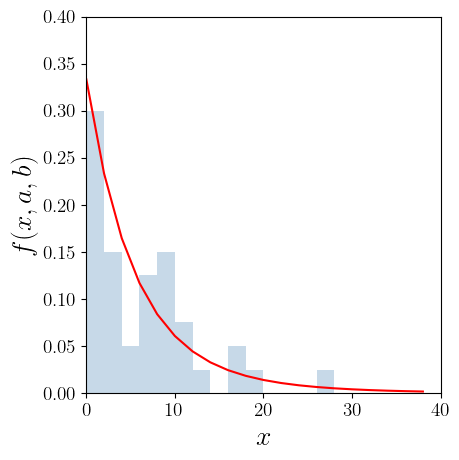

In [8]:
plot_data(X, F)

### Fit model $m(x | a, b) = p \, \exp(-x / a) / a + (1-p) \exp(-x / b) / b$ to data
The __iminuit__ module implements an interface identical to the one in scipy.optimize:
```python
results = im.minimize(fun, guess, [args=(..,)])
```
where
  * *fun* is the real scaler function $C(\theta)$ to be minimized, $\theta$ denotes its parameter vector, and
  * *guess* is an initial estimate of $\theta$.
  * *args* is an optional tuple of arguments to be passed to the function to be minimized.

### Covariance matrix
The minimizer computes an approximation to the Hessian matrix 
$
\begin{align*}
    H_{jk} &= \frac{\partial^2 C}{\partial \theta_j \partial \theta_k}, 
\end{align*}
$
and returns its inverse $\text{var}(\hat{\theta}) = H^{-1}$ evaluated at the best-fit value $\theta = \hat{\theta}$.

#### Results
The data structure __results__ contains
  * results.x: the fitted parameter values
  * results.fun: $C_\textrm{min}(\theta)$
  * results.hess_inv: inverse of Hessian matrix

### Define negative log-likelihood (nll)

Note this function has no additional arguments beyond the required array of parameters __params__.

In [9]:
def nll(params):
    a, b = params
    f    = np.log(F(X, a, b)) 
    return -f.sum()

nll.errdef = im.Minuit.LIKELIHOOD

### Perform  fit

In [10]:
def fit_model_to_data(nll, guess=[2, 15]):
    results= im.minimize(nll, guess)

    # estimate of parameters (best-fit values)
    mu = results.x
    a, b = mu
    
    # estimate of covariance matrix
    cov  = results.hess_inv

    da   = np.sqrt(cov[0][0])
    db   = np.sqrt(cov[1][1])
    print('a: %6.1f +/- %4.1f' % (a, da))
    print('b: %6.1f +/- %4.1f' % (b, db))

    # get value of -2*log(model) at best-fit value
    nll0 = 2*nll(results.x)

    # get value of Gaussian approximation of likelihood about maximum
    nllmvg0 =-2*np.log(st.multivariate_normal.pdf(mu, mu, cov)) 

    return results.x, results.hess_inv, nll0, nllmvg0

mu, cov, nll0, nllmvg0 = fit_model_to_data(nll)

a:    5.2 +/-  1.5
b:   11.2 +/-  3.9


### Subtract nll at best-fit value from nll

Do this for both the true likelihood and its Gaussian approximation.

In [11]:
def dnlmvg(a, b, min_nll, mu, cov):
    nllmvg = -2*np.log(st.multivariate_normal.pdf([a, b], mu, cov))
    return nllmvg - min_nll

def dnll(a, b, min_nll):
    return nll([a, b]) - min_nll

### Plot true likelihood and superimpose its Gaussian approximation

In [12]:
AMIN =  0.1
AMAX = 25
BMIN =  0.1
BMAX = 25

def compute_lhood(f, min_nll, 
                  mu=None, cov=None,
                  nsteps=100, 
                  xmin=AMIN, xmax=AMAX,
                  ymin=BMIN, ymax=BMAX):
    
    # 1. first create a mesh grid
    xdelta = float(xmax-xmin)/nsteps
    ydelta = float(ymax-ymin)/nsteps
    x      = np.arange(xmin, xmax, xdelta)
    y      = np.arange(ymin, ymax, ydelta)
    x, y   = np.meshgrid(x, y)
    
    # 2. compute likelihoods at all mesh grid points
    if type(mu) != type(None): 
        z = [f(a, b, min_nll, mu, cov) 
             for a, b in zip(x.flatten(), y.flatten())]
    else:
        z = [f(a, b, min_nll) 
             for a, b in zip(x.flatten(), y.flatten())]
        
    z = np.array(z).reshape(x.shape)
    z = np.exp(-z)

    return (x, y, z)

In [13]:
ll_true   = compute_lhood(dnll, nll0)
ll_approx = compute_lhood(dnlmvg, nllmvg0, mu, cov)

In [14]:
def plot_lhood(points,
               approx,
               filename='fig_likelihood.png',
               nsteps=50, 
               xmin=AMIN, xmax=AMAX, 
               ymin=BMIN, ymax=BMAX, 
               ftsize=20, 
               fgsize=(5, 5)):

    # set size of figure
    fig = plt.figure(figsize=fgsize)

    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    
    # annotate axes
    plt.xlabel(r'$a$', fontsize=ftsize)
    plt.ylabel(r'$b$', fontsize=ftsize)
    
    # plot contours
    rainbow = plt.get_cmap('rainbow')
    x, y, z = points
    plt.contour(x, y, z, cmap=rainbow)
  
    # plot contours
    earth   = plt.get_cmap('gist_earth')
    x, y, z = approx
    plt.contour(x, y, z, cmap=earth)
    
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()

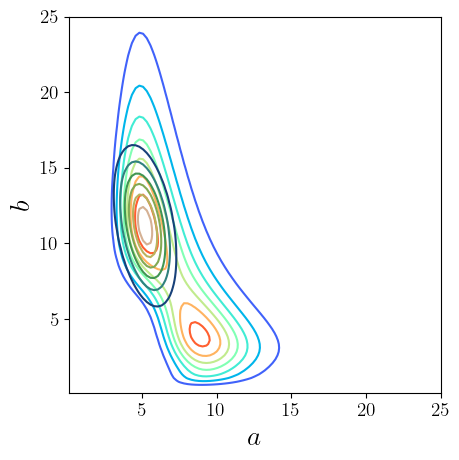

In [15]:
plot_lhood(ll_true, ll_approx)

In the __asymptotic__ limit (that is, as the amount of data goes to infinity) the likelihood function will become approximately Gaussian provided the usual "regularity conditions" are satisfied. (See Sara Algeri's seminar: https://www.youtube.com/watch?v=e0Y9QszyO1E for details.)   
Clearly, in this example the likelihood function is far from the asymptotic regime. Moreover, it is multi-modal! 

### Increase sample size and re-fit 

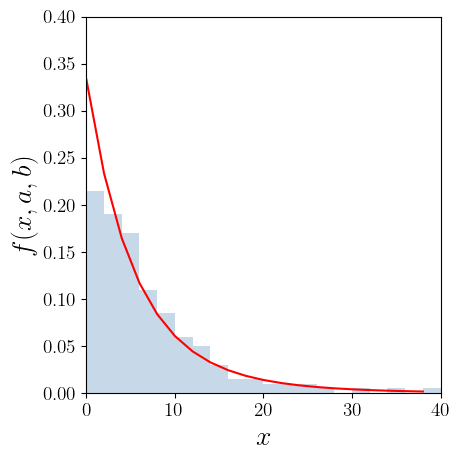

a:    5.7 +/-  0.8
b:   10.4 +/-  1.8


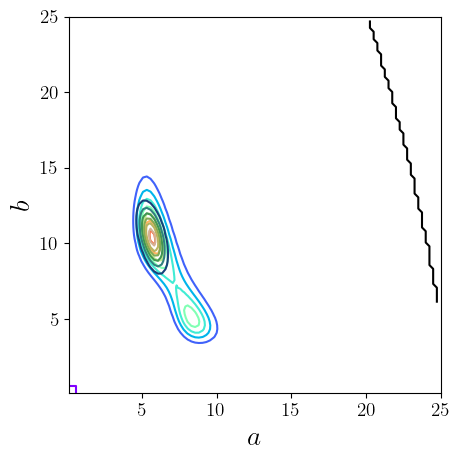

In [16]:
_, _, _, _, X = read_data('likelihood_data_80.txt')
plot_data(X, F)

mu, cov, nll0, nllmvg0 = fit_model_to_data(nll)

ll_true   = compute_lhood(dnll, nll0)
ll_approx = compute_lhood(dnlmvg, nllmvg0, mu, cov)

plot_lhood(ll_true, ll_approx, filename='fig_likelihood_80.png')